# Coupled Decomposition - Part I

In [1]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs

# A method to resize the images on the fly.
from scipy.misc import imresize

# Fundamental matrix computation
from autocnet.transformation import fundamental_matrix as fm

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## CandidateGraph -> Custom Extraction Func -> Matching -> Coupled Decomposition

In [2]:
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Enable the GPU
autocnet.cuda(enable=True, gpu=0)

# Write a custom keypoint extraction function - this could get monkey patched onto the graph object...
def extract(arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr0.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    return kp, des, sd, downsample_amount, arr

arr0 = cg.node[0].geodata.read_array()
kp0, des0, sd0, downsample_amount0, arr0 = extract(arr0, thresh=1)

arr1 = cg.node[1].geodata.read_array()
kp1, des1, sd1, downsample_amount1, arr1 = extract(arr1, thresh=1)


# Now apply matching, outlier detection, and compute a fundamental matrix
sd0 = cs.PySiftData.from_data_frame(kp0, des0)
sd1 = cs.PySiftData.from_data_frame(kp1, des1)

# Apply the matcher
cs.PyMatchSiftData(sd0, sd1)
matches, _ = sd0.to_data_frame()
submatches = matches.query('ambiguity <= 0.95 and score >= 0.925310')


In [3]:
# Use the query capability to reduce the number of correspondences
sd0 = cs.PySiftData.from_data_frame(kp0, des0)
sd1 = cs.PySiftData.from_data_frame(kp1, des1)
# Apply the matcher
cs.PyMatchSiftData(sd0, sd1)

matches, _ = sd0.to_data_frame()
submatches = matches.query('ambiguity <= 0.95 and score >= 0.925310')

kpa = submatches[['x','y']]
kpb = submatches[['match_xpos', 'match_ypos']]

F, mask = fm.compute_fundamental_matrix(kpa, kpb, method='ransac', reproj_threshold=2.0)
F = fm.enforce_singularity_constraint(F)

inliers = submatches[mask]

## Coupled Decomposition

Broadly, a key problem with matching large images is the inherent ambiguity in correspondence identifiction.  As the image size increases, so does the candidate correspondence count.  The probability of finding a correct correspondence amongst all of the erroneous correspondences then decreases to the point where disambiguous correspondences can not be identified.  Coupled decomposition seaks to recursively partition images into corresponding regions so that the matching problem can constrainted to a limited number of pixels.

It is possible to utilize initial matches, at reduced resolution to identify points for partioning.  We demonstrate this process below.

In [4]:
# Select the correspondence nearest to the middle of the image.  We decompose into quadrants, so a mid-point is preferable for this data.
midx = arr0.shape[1] / 2
midy = arr0.shape[0] / 2

from scipy.spatial.distance import cdist
mid = np.array([[midx, midy]])
dists = cdist(mid, inliers[['x', 'y']])
mid_correspondence = inliers.iloc[np.argmin(dists)]
mid_correspondence

x              5391.526855
y               127.788239
scale            10.814593
sharpness         1.617509
edgeness          4.384637
orientation     242.035156
score             0.967968
ambiguity         0.927719
match          1236.000000
match_xpos     5431.506348
match_ypos     2015.922729
match_error       0.000000
subsampling       0.000000
Name: 295, dtype: float32

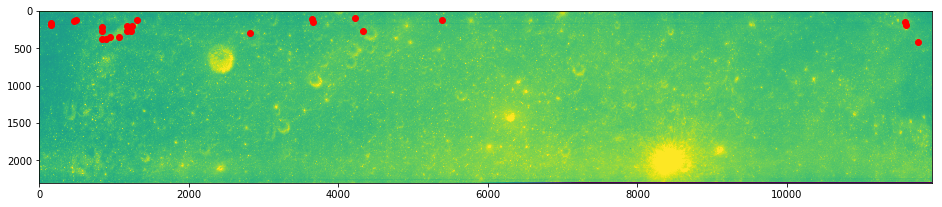

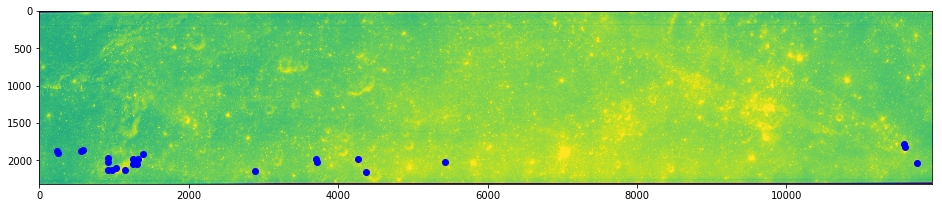

In [5]:
imshow(arr0)
plot(inliers.x, inliers.y, 'ro')
show()
imshow(arr1)
plot(inliers.match_xpos, inliers.match_ypos, 'bo')

This is going to take a little while.  The team is working on a CUDA version that is super faster, but it is not ready yet.

In [37]:
# Apply the decomposition algorithm
from autocnet.transformation.decompose import coupled_decomposition
smembership, dmembership = coupled_decomposition(arr0, arr1,
                                                 sorigin=mid_correspondence[['x', 'y']],
                                                 dorigin=mid_correspondence[['match_xpos', 'match_ypos']])


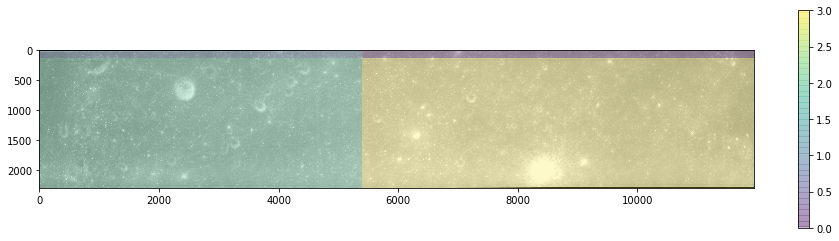

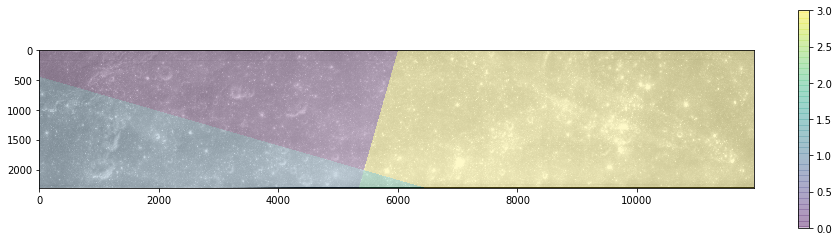

In [38]:
imshow(arr0, cmap='gray')
imshow(smembership, alpha=0.25)
colorbar()
show()

imshow(arr1, cmap='gray')
imshow(dmembership, alpha=0.25)
colorbar()

## Failure & Solution

The shear size of these images is causing the rotational invariance method to idenfity a high level of correlation between the source image and a pretty rotated destination image.  Here we can fix that by simply passing in a known rotation (theta in radians).  We know these images are *barely* rotated...  

Processing is also a lot faster since we are not searching all potential rotation angles (the default is 1/2 degree increments).

In [39]:
smembership, dmembership, = coupled_decomposition(arr0, arr1,
                                                 sorigin=mid_correspondence[['x', 'y']],
                                                 dorigin=mid_correspondence[['match_xpos', 'match_ypos']],
                                                 theta=-math.radians(1))



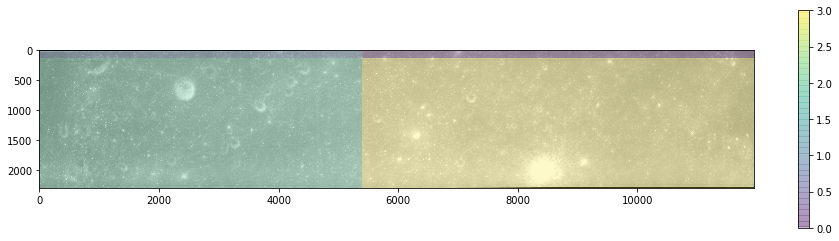

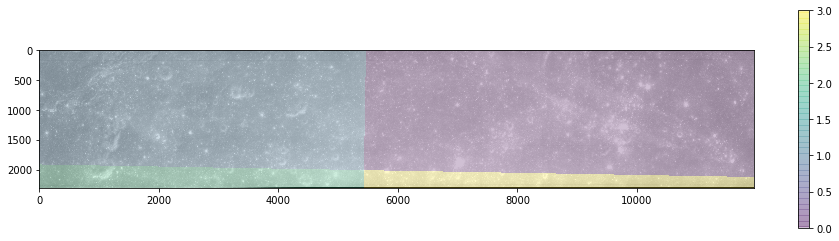

In [40]:
imshow(arr0, cmap='gray')
imshow(smembership, alpha=0.25)
colorbar()
show()

imshow(arr1, cmap='gray')
imshow(dmembership, alpha=0.25)
colorbar()

Now the matching problem has been reduced in size from !2500x12000 pixels to four smaller subregion.